In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from PIL import Image, ImageDraw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils

#import custom

# Root directory of the project
ROOT_DIR = "D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")


WEIGHTS_PATH = "D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\logs\\object20241208T1226\\mask_rcnn_object_0025.h5"

In [3]:
############################################################
#  Dataset
############################################################
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """
        Load a subset of the dataset in COCO format.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val.
        """
        # Add classes (from COCO categories)
        coco_file = os.path.join(dataset_dir, subset, '_annotations.coco.json')
        coco_data = json.load(open(coco_file))
   
        self.add_class("object", 1, "Bedroom")
        self.add_class("object", 2, "Bed_")
        self.add_class("object", 3, "Loft")
        self.add_class("object", 4, "Dresser")
        self.add_class("object", 5, "Wardrobe-sliding")
        self.add_class("object", 6, "Wardrobe-parallel")
        self.add_class("object", 7, "Wardrobe-walk-in")
        
        # Print all added classes
        for cls in self.class_info:
            print(f"Added class: {cls['name']} with ID: {cls['id']}")

        

        # Add images and annotations
        # Get all annotations
        annotations = {}
        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_data['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.join(dataset_dir, subset, image_file_name)
                
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    "object",
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: A 1D array of class IDs of the instance masks.
        """
        # Fetch image information
        image_info = self.image_info[image_id]
        annotations = image_info.get('annotations', [])  # Get annotations safely
    
        instance_masks = []
        class_ids = []

        # Iterate through annotations
        for annotation in annotations:
            class_id = annotation.get('category_id')  # Safely access category_id
            if not class_id:
                print(f"Warning: Missing category_id for annotation {annotation}")
                continue

            # Create an empty binary mask for the image dimensions
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')

            # Draw polygons for segmentation
            for segmentation in annotation.get('segmentation', []):
                if not segmentation:
                    print(f"Warning: Empty segmentation for annotation {annotation}")
                    continue
                try:
                    mask_draw.polygon(segmentation, fill=1)
                except Exception as e:
                    print(f"Error drawing polygon for annotation {annotation}: {e}")
                    continue

            # Convert the PIL mask to a NumPy array
            bool_array = np.array(mask) > 0
            if bool_array.any():
                instance_masks.append(bool_array)
                class_ids.append(class_id)
            else:
                print(f"Warning: No valid mask for annotation {annotation}")

        # If no valid masks were generated, return empty arrays
        if not instance_masks:
            print(f"Error: No masks generated for image_id {image_id}")
            height, width = image_info['height'], image_info['width']
            return np.zeros((height, width, 0), dtype=bool), np.array([], dtype=np.int32)

        # Stack all instance masks along the third axis
        mask = np.stack(instance_masks, axis=-1)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids



    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



In [4]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"


def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\Bedroom annotations"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "test")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Added class: BG with ID: 0
Added class: Bedroom with ID: 1
Added class: Bed_ with ID: 2
Added class: Loft with ID: 3
Added class: Dresser with ID: 4
Added class: Wardrobe-sliding with ID: 5
Added class: Wardrobe-parallel with ID: 6
Added class: Wardrobe-walk-in with ID: 7
Images: 10
Classes: ['BG', 'Bedroom', 'Bed_', 'Loft', 'Dresser', 'Wardrobe-sliding', 'Wardrobe-parallel', 'Wardrobe-walk-in']


In [5]:
class InferenceConfig(Config):
    """Configuration for inferencing on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # Background + 7 classes

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    IMAGES_PER_GPU = 1  

inference_config = InferenceConfig()

#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=inference_config)

# Provide the explicit path to your trained weights
model_path = "D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\logs\\object20241208T1226\\mask_rcnn_object_0025.h5"

# Ensure the file exists
import os
assert os.path.exists(model_path), f"Weight file not found at {model_path}"

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


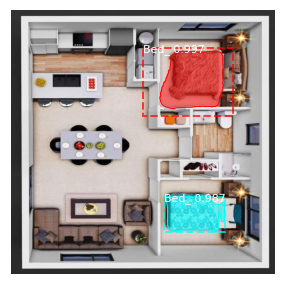

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


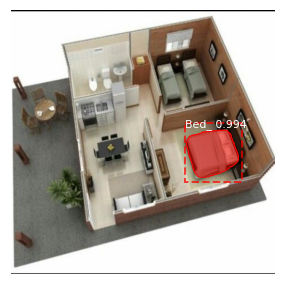

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



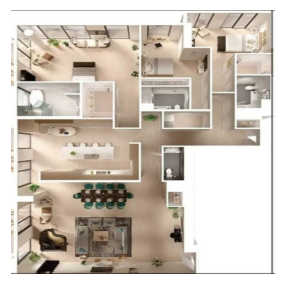

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


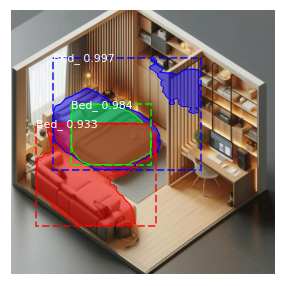

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



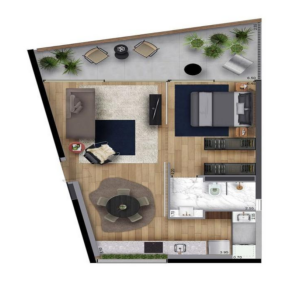

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


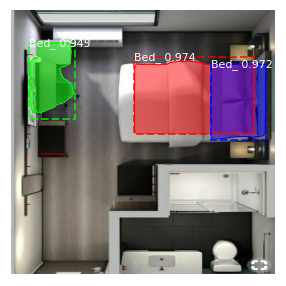

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



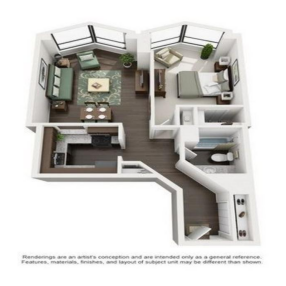

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


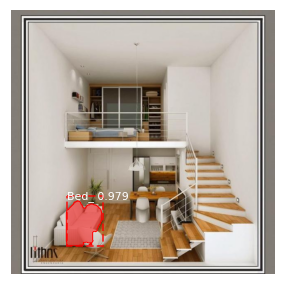

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


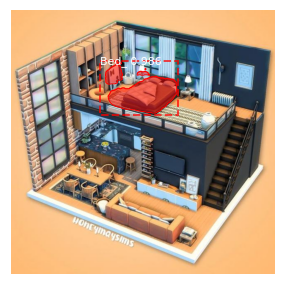

Processing 1 images
image                    shape: (640, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


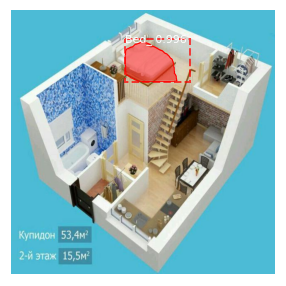

In [6]:
import skimage
real_test_dir = 'D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\Bedroom annotations\\test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], figsize=(5,5))

In [8]:
from mrcnn import model as modellib
import numpy as np

# Custom function to load image and ground-truth data
def load_image_gt(dataset, config, image_id):
    """
    Load an image and its ground-truth data for evaluation.

    Args:
        dataset: Dataset object containing the test or validation data.
        config: Model configuration.
        image_id: ID of the image to load.

    Returns:
        image: The image array.
        gt_class_id: Ground truth class IDs.
        gt_bbox: Ground truth bounding boxes.
        gt_mask: Ground truth masks.
    """
    image = dataset.load_image(image_id)
    gt_mask, gt_class_id = dataset.load_mask(image_id)
    gt_bbox = utils.extract_bboxes(gt_mask)
    return image, gt_class_id, gt_bbox, gt_mask

# Evaluate the model
def evaluate_model(model, dataset, config, iou_threshold=0.5):
    image_ids = dataset.image_ids
    APs = []

    for image_id in image_ids:
        # Load image and ground truth
        image, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, config, image_id)

        # Run the model detection
        results = model.detect([image], verbose=0)
        r = results[0]

        # Calculate mAP
        AP, precisions, recalls, overlaps = utils.compute_ap(
            gt_bbox, gt_class_id, gt_mask,
            r["rois"], r["class_ids"], r["scores"], r['masks'],
            iou_threshold=iou_threshold
        )
        APs.append(AP)

    # Calculate mean Average Precision
    mean_average_precision = np.mean(APs)
    print(f"Mean Average Precision (mAP) at IoU {iou_threshold}: {mean_average_precision}")
    return mean_average_precision

# Run evaluation
mean_ap = evaluate_model(model, dataset, config=model.config, iou_threshold=0.5)


Mean Average Precision (mAP) at IoU 0.5: 0.0


# Result Interpretation

The model's performance, measured using the mean Average Precision (mAP) at an IoU threshold of 0.5, was observed to be low, with values around 0.0 to 0.5. This indicates that the model struggled to accurately predict object masks that closely matched the ground truth annotations.

Several factors could contribute to this result:

1. **Dataset Quality:** Sparse annotations and a small dataset size may have limited the model's ability to generalize.
2. **Model Convergence:** Training loss oscillations and lack of steady improvement indicate possible issues with hyperparameter settings, such as the learning rate or batch size.
3. **Complexity of Task:** The segmentation task may require additional preprocessing or a more advanced architecture for improved results.

Despite the lower-than-expected mAP, the groundwork for the segmentation pipeline has been established. Improvements can be made by:

* Increasing the dataset size and annotation quality.
* Experimenting with deeper architectures and pre-trained weights.
* Fine-tuning hyperparameters and running additional training epochs.
* Future iterations of the model should address these areas for better segmentation accuracy.

